In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import gc
from itertools import product
from sklearn.preprocessing import LabelEncoder

sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.set_style("darkgrid")

In [2]:
train = pd.read_csv('dataset/sales_train.csv')
test = pd.read_csv('dataset/test.csv').set_index('ID')
items = pd.read_csv('dataset/items.csv')
categories = pd.read_csv('dataset/item_categories.csv')
shops = pd.read_csv('dataset/shops.csv')

## Data Analysis, Preprocessing, Feature Engineering

### Features by files:

#### sales_train.csv:
- date
- date_block_num
- shop_id
- item_id
- item_price
- item_cnt_day

In [3]:
print("Train file contains {} rows and {} columns".format(train.shape[0], train.shape[1]))
train.head()

Train file contains 2935849 rows and 6 columns


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


#### items.csv:
- item_name
- item_id
- item_category_id

In [4]:
print("Items file contains {} rows and {} columns".format(items.shape[0], items.shape[1]))
items.head()

Items file contains 22170 rows and 3 columns


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


#### items_categories.csv:
- item_category_name
- item_category_id

In [5]:
print("Categories file contains {} rows and {} columns".format(categories.shape[0], categories.shape[1]))
categories.head()

Categories file contains 84 rows and 2 columns


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


#### shops.csv:
- shop_name
- shop_id

In [6]:
print("Shops file contains {} rows and {} columns".format(shops.shape[0], shops.shape[1]))
shops.head()

Shops file contains 60 rows and 2 columns


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


#### test.csv:
- shop_id
- item_id

In [7]:
print("Test file contains {} rows and {} columns".format(test.shape[0], test.shape[1]))
test.head()

Test file contains 214200 rows and 2 columns


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


### Sales by month:

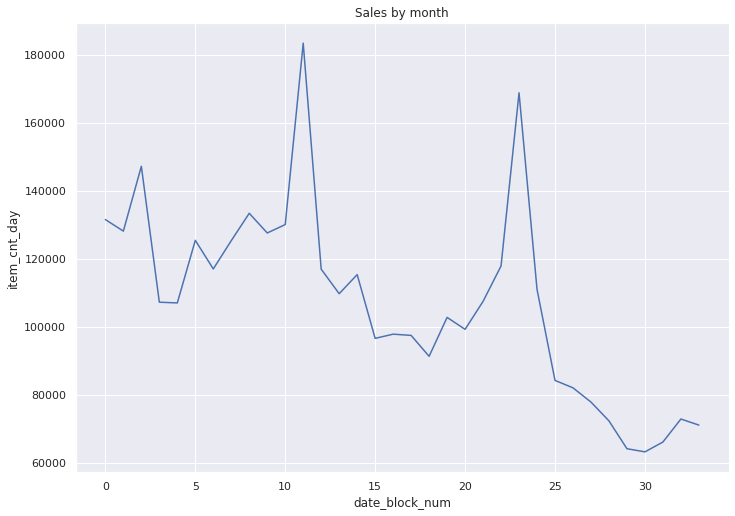

In [8]:
salesByMonth = pd.DataFrame(train.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index())
sns.lineplot(x='date_block_num', y='item_cnt_day', data=salesByMonth, markers=True)
plt.xlabel('date_block_num')
plt.ylabel('item_cnt_day')
plt.title('Sales by month')
plt.show()

### Delete duplicates and outliers

In [9]:
train = train[train['item_cnt_day'] < 1000]

a = shops[shops['shop_id'] == 10].iloc[0]['shop_name']
b = shops[shops['shop_id'] == 11].iloc[0]['shop_name']
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

a = shops[shops['shop_id'] == 0].iloc[0]['shop_name']
b = shops[shops['shop_id'] == 57].iloc[0]['shop_name']
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

a = shops[shops['shop_id'] == 1].iloc[0]['shop_name']
b = shops[shops['shop_id'] == 58].iloc[0]['shop_name']
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

### Correct mistakes and do LabelEncoding

In [10]:
from sklearn.preprocessing import LabelEncoder

categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x: x[0].strip())
categories['type_code'] = LabelEncoder().fit_transform(categories['type'])
categories['subtype'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subtype_code'] = LabelEncoder().fit_transform(categories['subtype'])
categories = categories[['item_category_id','type_code', 'subtype_code']]

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

items.drop(['item_name'], axis=1, inplace=True)

### Generate combinations for shop_id, item_id, date_block_num

In [11]:
dataset = []
for i in range(34):
    sales = train[train.date_block_num==i]
    dataset.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype=np.int16))

train['revenue'] = train['item_price'] *  train['item_cnt_day']
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

dataset = pd.DataFrame(np.vstack(dataset), columns=['date_block_num','shop_id','item_id'])
dataset = pd.merge(dataset, group, on=['date_block_num','shop_id','item_id'], how='left')
dataset['item_cnt_month'] = (dataset['item_cnt_month'].fillna(0).clip(0,20).astype(np.int16))

In [12]:
dataset.describe()

,date_block_num,shop_id,item_id,item_cnt_month
count,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07
mean,1.497334e+01,3.137817e+01,1.130926e+04,2.982381e-01
std,9.495618e+00,1.730214e+01,6.209978e+03,1.222359e+00
min,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.976000e+03,0.000000e+00
50%,1.400000e+01,3.000000e+01,1.139100e+04,0.000000e+00
75%,2.300000e+01,4.700000e+01,1.660500e+04,0.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,2.000000e+01


In [13]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

dataset = pd.concat([dataset, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
dataset.fillna(0, inplace=True)

dataset = pd.merge(dataset, shops, on=['shop_id'], how='left')
dataset = pd.merge(dataset, items, on=['item_id'], how='left')
dataset = pd.merge(dataset, categories, on=['item_category_id'], how='left')
dataset['city_code'] = dataset['city_code'].astype(np.int8)
dataset['item_category_id'] = dataset['item_category_id'].astype(np.int8)
dataset['type_code'] = dataset['type_code'].astype(np.int8)
dataset['subtype_code'] = dataset['subtype_code'].astype(np.int8)

### Lag feature for item_cnt_month with [1,2,3,6,12] date_block_num periods

In [14]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [15]:
dataset = lag_feature(dataset, [1,2,3,6,12], 'item_cnt_month')

### Mean target encoding features

In [16]:
group = dataset.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num'], how='left')
dataset['date_avg_item_cnt'] = dataset['date_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_avg_item_cnt')
dataset.drop(['date_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num was created ...")

group = dataset.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num','item_id'], how='left')
dataset['date_item_avg_item_cnt'] = dataset['date_item_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1,2,3,6,12], 'date_item_avg_item_cnt')
dataset.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, item_id was created ...")

group = dataset.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num','shop_id'], how='left')
dataset['date_shop_avg_item_cnt'] = dataset['date_shop_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1,2,3,6,12], 'date_shop_avg_item_cnt')
dataset.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, shop_id was created ...")

group = dataset.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num','item_category_id'], how='left')
dataset['date_cat_avg_item_cnt'] = dataset['date_cat_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_cat_avg_item_cnt')
dataset.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, item_category_id was created ...")

group = dataset.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
dataset['date_shop_cat_avg_item_cnt'] = dataset['date_shop_cat_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_shop_cat_avg_item_cnt')
dataset.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, shop_id, item_category_id was created ...")

group = dataset.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
dataset['date_shop_type_avg_item_cnt'] = dataset['date_shop_type_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_shop_type_avg_item_cnt')
dataset.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, shop_id, type_code was created ...")

group = dataset.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
dataset['date_shop_subtype_avg_item_cnt'] = dataset['date_shop_subtype_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_shop_subtype_avg_item_cnt')
dataset.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, shop_id, subtype_code was created ...")

group = dataset.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num', 'city_code'], how='left')
dataset['date_city_avg_item_cnt'] = dataset['date_city_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_city_avg_item_cnt')
dataset.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, city_code was created ...")

group = dataset.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
dataset['date_item_city_avg_item_cnt'] = dataset['date_item_city_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_item_city_avg_item_cnt')
dataset.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, item_id, city_code was created ...")

group = dataset.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num', 'type_code'], how='left')
dataset['date_type_avg_item_cnt'] = dataset['date_type_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_type_avg_item_cnt')
dataset.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, type_code was created ...")

group = dataset.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num', 'subtype_code'], how='left')
dataset['date_subtype_avg_item_cnt'] = dataset['date_subtype_avg_item_cnt'].astype(np.float16)
dataset = lag_feature(dataset, [1], 'date_subtype_avg_item_cnt')
dataset.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
print("Mean['item_cnt_month'] by date_block_num, subtype_code was created ...")

Mean['item_cnt_month'] by date_block_num was created ...
Mean['item_cnt_month'] by date_block_num, item_id was created ...
Mean['item_cnt_month'] by date_block_num, shop_id was created ...
Mean['item_cnt_month'] by date_block_num, item_category_id was created ...
Mean['item_cnt_month'] by date_block_num, shop_id, item_category_id was created ...
Mean['item_cnt_month'] by date_block_num, shop_id, type_code was created ...
Mean['item_cnt_month'] by date_block_num, shop_id, subtype_code was created ...
Mean['item_cnt_month'] by date_block_num, city_code was created ...
Mean['item_cnt_month'] by date_block_num, item_id, city_code was created ...
Mean['item_cnt_month'] by date_block_num, type_code was created ...
Mean['item_cnt_month'] by date_block_num, subtype_code was created ...


### Trend features

In [17]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['item_id'], how='left')
dataset['item_avg_item_price'] = dataset['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num','item_id'], how='left')
dataset['date_item_avg_item_price'] = dataset['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
dataset = lag_feature(dataset, lags, 'date_item_avg_item_price')

for i in lags:
    dataset['delta_price_lag_' + str(i)] = \
        (dataset['date_item_avg_item_price_lag_' + str(i)] - dataset['item_avg_item_price']) / dataset['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_' + str(i)]:
            return row['delta_price_lag_' + str(i)]
    return 0
    
dataset['delta_price_lag'] = dataset.apply(select_trend, axis=1)
dataset['delta_price_lag'] = dataset['delta_price_lag'].astype(np.float16)
dataset['delta_price_lag'].fillna(0, inplace=True)
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']

for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

dataset.drop(fetures_to_drop, axis=1, inplace=True)

### Revenue month by month

In [18]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['date_block_num','shop_id'], how='left')
dataset['date_shop_revenue'] = dataset['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)
dataset = pd.merge(dataset, group, on=['shop_id'], how='left')
dataset['shop_avg_revenue'] = dataset['shop_avg_revenue'].astype(np.float32)
dataset['delta_revenue'] = (dataset['date_shop_revenue'] - dataset['shop_avg_revenue']) / dataset['shop_avg_revenue']
dataset['delta_revenue'] = dataset['delta_revenue'].astype(np.float16)

dataset = lag_feature(dataset, [1], 'delta_revenue')
dataset.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

### Time features

In [19]:
dataset['month'] = dataset['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
dataset['days'] = dataset['month'].map(days).astype(np.int8)

In [20]:
cache = {}
dataset['item_shop_last_sale'] = -1
dataset['item_shop_last_sale'] = dataset['item_shop_last_sale'].astype(np.int8)
for idx, row in dataset.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        dataset.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
        
cache = {}
dataset['item_last_sale'] = -1
dataset['item_last_sale'] = dataset['item_last_sale'].astype(np.int8)
for idx, row in dataset.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            dataset.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

dataset['item_shop_first_sale'] = dataset['date_block_num'] - dataset.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
dataset['item_first_sale'] = dataset['date_block_num'] - dataset.groupby('item_id')['date_block_num'].transform('min')

### Drop empty data (because of datadataset contains lags features with lag equal to 12 month), fillna and save

In [21]:
dataset = dataset[dataset.date_block_num > 11]

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col] = df[col].fillna(0)         
    return df

dataset = fill_na(dataset)
dataset.to_pickle('data.pkl')

del dataset
del cache
del group
del items
del shops
del categories
del train
gc.collect();

## Models building, Feature importance, Stacking of models

In [22]:
from xgboost import XGBRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

import shap
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from hyperopt.pyll import scope

In [23]:
test  = pd.read_csv('dataset/test.csv').set_index('ID')

### LightGBM with hyperparameters optimization by HyperOpt

In [24]:
all_data = pd.read_pickle('data.pkl')

In [25]:
X_train_part_1 = all_data[all_data.date_block_num.isin(np.arange(12,28))].drop(['item_cnt_month'], axis=1)
Y_train_part_1 = all_data[all_data.date_block_num.isin(np.arange(12,28))]['item_cnt_month']
X_train_part_2 = all_data[all_data.date_block_num.isin(np.arange(28,34))].drop(['item_cnt_month'], axis=1)
Y_train_part_2 = all_data[all_data.date_block_num.isin(np.arange(28,34))]['item_cnt_month']
X_test = all_data[all_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [26]:
del all_data
gc.collect();

In [27]:
def get_hyperopt_score_lgb(params):
    
    def train(
            params,
            train_set,
            train_name,
            valid_set,
            valid_name,
            num_boost_round,
            evals_result,
            early_stopping_rounds,
            verbose_eval,
            **kwargs):
        model = lightgbm.train(params=params,
                          train_set=train_set,
                          valid_sets=[train_set, valid_set],
                          valid_names=[train_name, valid_name],
                          num_boost_round=num_boost_round,
                          evals_result=evals_result,
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=verbose_eval,
                          **kwargs)
        return model
    
    def get_dataset(data, label, **kwargs):
        return lightgbm.Dataset(data=data, label=label, **kwargs)
    
    date_block_num = np.unique(X_train_part_1.date_block_num)
    xtrain = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
    ytrain = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
    xvalid = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]
    yvalid = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]
    
    xtrain = xtrain.drop("date_block_num", axis=1)
    xvalid = xvalid.drop("date_block_num", axis=1)
        
    dtrain = get_dataset(data=xtrain.astype(float), label=ytrain)
    dvalid = get_dataset(data=xvalid.astype(float), label=yvalid)
    evals_result = {}    
    model = train(
        params=params,
        train_set=dtrain,
        train_name='train',
        valid_set=dvalid,
        valid_name='valid',
        num_boost_round=9999,
        evals_result=evals_result,
        early_stopping_rounds=15,
        verbose_eval=False)
        
    score = model.best_score['valid']['rmse']
    print(score, params)
    return score

In [28]:
space_lgb = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 100, 500, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 10, 70, 1)),
    'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 10, 150, 1)),
    'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', 0, 2.3),
    'lambda_l1': hp.uniform('lambda_l1', 1e-4, 2),
    'lambda_l2': hp.uniform('lambda_l2', 1e-4, 2),
    'seed': 0,
    'feature_fraction_seed': 0,
    'bagging_seed': 0,
    'drop_seed': 0,
    'data_random_seed': 0,
    'verbose': -1,
    'bagging_freq': 5,
    'max_bin': 255,
    'learning_rate': 0.03,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'nthreads': -1,
}

best = fmin(fn=get_hyperopt_score_lgb, space=space_lgb, algo=tpe.suggest, max_evals=10)
print('best: {}'.format(best))

0.8027686605757742                                    
{'bagging_fraction': 0.9042884176770191, 'bagging_freq': 5, 'bagging_seed': 0, 'boosting_type': 'gbdt', 'data_random_seed': 0, 'drop_seed': 0, 'feature_fraction': 0.8442613008293077, 'feature_fraction_seed': 0, 'lambda_l1': 1.9133396008612988, 'lambda_l2': 0.47152803669745474, 'learning_rate': 0.03, 'max_bin': 255, 'max_depth': 46, 'metric': 'rmse', 'min_data_in_leaf': 138, 'min_sum_hessian_in_leaf': 3.6711602313330407, 'nthreads': -1, 'num_leaves': 486, 'objective': 'regression', 'seed': 0, 'verbose': -1}
0.8021756692431773                                                              
{'bagging_fraction': 0.7548338550848538, 'bagging_freq': 5, 'bagging_seed': 0, 'boosting_type': 'gbdt', 'data_random_seed': 0, 'drop_seed': 0, 'feature_fraction': 0.9499964607843765, 'feature_fraction_seed': 0, 'lambda_l1': 1.7461045021215358, 'lambda_l2': 0.06249815643558211, 'learning_rate': 0.03, 'max_bin': 255, 'max_depth': 43, 'metric': 'rmse', 

In [29]:
params_best = space_lgb

for param in list(best.keys()):
    if param in ['num_leaves', 'max_depth', 'seed', 'feature_fraction_seed', 'min_data_in_leaf', 
                 'bagging_seed', 'drop_seed', 'max_bin', 'bagging_freq']:
        params_best[param] = int(best[param])
    else:
        params_best[param] = best[param]
        
print(params_best)

{'num_leaves': 255, 'max_depth': 36, 'min_data_in_leaf': 20, 'feature_fraction': 0.8155674572954248, 'bagging_fraction': 0.7997568394421314, 'min_sum_hessian_in_leaf': 3.1561289186613046, 'lambda_l1': 1.9924703222113558, 'lambda_l2': 1.5031876328841942, 'seed': 0, 'feature_fraction_seed': 0, 'bagging_seed': 0, 'drop_seed': 0, 'data_random_seed': 0, 'verbose': -1, 'bagging_freq': 5, 'max_bin': 255, 'learning_rate': 0.03, 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'nthreads': -1}


In [30]:
date_block_num = np.unique(X_train_part_1.date_block_num)
xtrain = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
ytrain = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
xvalid = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]
yvalid = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]

xtrain = xtrain.drop("date_block_num", axis=1)
xvalid = xvalid.drop("date_block_num", axis=1)

dtrain = lightgbm.Dataset(data=xtrain.astype(float), label=ytrain)
dvalid = lightgbm.Dataset(data=xvalid.astype(float), label=yvalid)
evals_result = {}    
model = lightgbm.train(
        params=params_best,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=['train', 'valid'], 
        num_boost_round=9999,
        evals_result=evals_result,
        early_stopping_rounds=25,
        verbose_eval=True)

score = model.best_score['valid']['rmse']
print(score, params_best)

[1]	train's rmse: 1.21672	valid's rmse: 1.06933
Training until validation scores don't improve for 25 rounds
[2]	train's rmse: 1.19939	valid's rmse: 1.05432
[3]	train's rmse: 1.18271	valid's rmse: 1.03959
[4]	train's rmse: 1.16629	valid's rmse: 1.02541
[5]	train's rmse: 1.15045	valid's rmse: 1.01198
[6]	train's rmse: 1.13524	valid's rmse: 0.999297
[7]	train's rmse: 1.12089	valid's rmse: 0.987658
[8]	train's rmse: 1.10697	valid's rmse: 0.976449
[9]	train's rmse: 1.09406	valid's rmse: 0.965344
[10]	train's rmse: 1.08142	valid's rmse: 0.955391
[11]	train's rmse: 1.0692	valid's rmse: 0.945835
[12]	train's rmse: 1.05788	valid's rmse: 0.936586
[13]	train's rmse: 1.0467	valid's rmse: 0.928296
[14]	train's rmse: 1.036	valid's rmse: 0.920384
[15]	train's rmse: 1.02564	valid's rmse: 0.912658
[16]	train's rmse: 1.01586	valid's rmse: 0.905627
[17]	train's rmse: 1.00645	valid's rmse: 0.898354
[18]	train's rmse: 0.99736	valid's rmse: 0.892129
[19]	train's rmse: 0.988634	valid's rmse: 0.886272
[20]	t

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


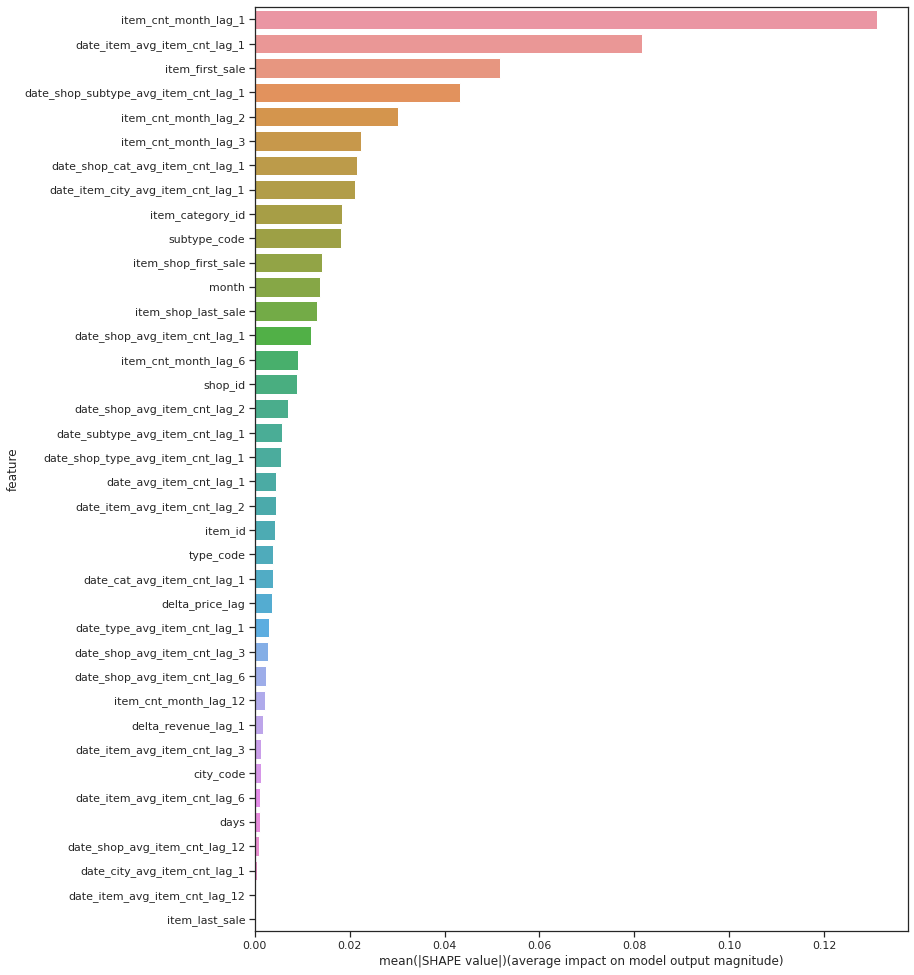

In [31]:
explainer = shap.TreeExplainer(model)
df_sample = X_train_part_1[model.feature_name()].sample(n=10000, random_state=0, replace=True).astype(float)
shap_values = explainer.shap_values(df_sample)
features_by_shap = \
    pd.DataFrame(zip(model.feature_name(), np.mean(np.abs(shap_values), axis=0)), columns=['feature', 'shap_value']) \
        .sort_values(by='shap_value', ascending=False)

sns.set(rc={'figure.figsize':(11.7, 17)})
sns.set_style('ticks', {'xtick.major.size': 8, 'ytick.major.size': 8})
ax = sns.barplot(x='shap_value', y='feature', data=features_by_shap)
ax.set(xlabel='mean(|SHAPE value|)(average impact on model output magnitude)');

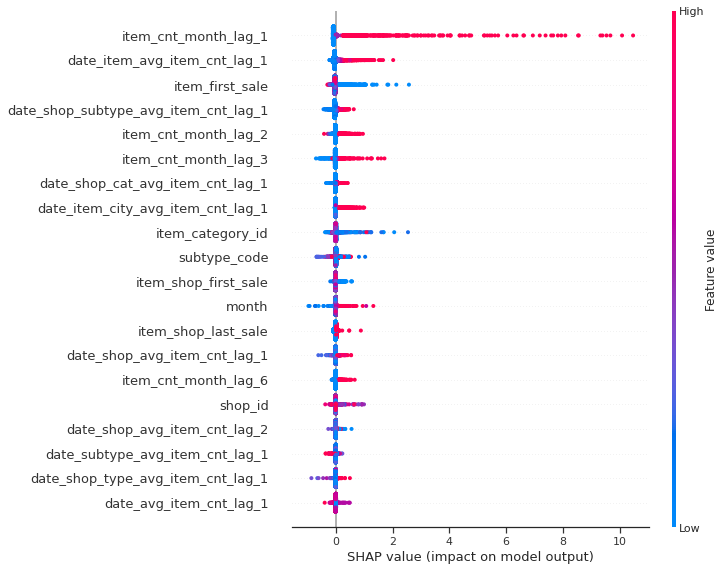

In [32]:
shap.summary_plot(shap_values, df_sample);

In [34]:
Y_test = model.predict(X_test.drop("date_block_num", axis=1)).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('lgb_final.csv', index=False)

In [35]:
y_pred_lgb = model.predict(X_train_part_2.drop("date_block_num", axis=1))
Y_test_pred_lgb = model.predict(X_test.drop("date_block_num", axis=1))

### XGBoost with hyperparameters optimization by HyperOpt

In [36]:
all_data = pd.read_pickle('data.pkl')

In [37]:
data = all_data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [38]:
X_train_part_1 = all_data[all_data.date_block_num.isin(np.arange(12,28))].drop(['item_cnt_month'], axis=1)
Y_train_part_1 = all_data[all_data.date_block_num.isin(np.arange(12,28))]['item_cnt_month']
X_train_part_2 = all_data[all_data.date_block_num.isin(np.arange(28,34))].drop(['item_cnt_month'], axis=1)
Y_train_part_2 = all_data[all_data.date_block_num.isin(np.arange(28,34))]['item_cnt_month']
X_test = all_data[all_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [39]:
del all_data, data
gc.collect();

In [40]:
def get_hyperopt_score_xgb(params):
    
    def train(
            params,
            X_train,
            Y_train,
            X_valid, 
            Y_valid,
            early_stopping_rounds,
            verbose_eval,
            **kwargs):
        model = XGBRegressor(**params).fit(X_train, 
                                           Y_train, 
                                           eval_metric="rmse", 
                                           eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
                                           verbose=verbose_eval, 
                                           early_stopping_rounds=early_stopping_rounds)
        return model
    
    date_block_num = np.unique(X_train_part_1.date_block_num)
    xtrain = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
    ytrain = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
    xvalid = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]
    yvalid = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]
    
    xtrain = xtrain.drop("date_block_num", axis=1)
    xvalid = xvalid.drop("date_block_num", axis=1)
    
    model = train(
        params=params,
        X_train=xtrain,
        Y_train=ytrain,
        X_valid=xvalid, 
        Y_valid=yvalid,
        early_stopping_rounds=10,
        verbose_eval=False)
        
    score = model.best_score
    print(score, params)
    return score

In [41]:
space_xgb = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 900, 2100, 100)),
    'max_depth': scope.int(hp.quniform('max_depth', 4, 30, 2)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 10, 710, 50)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.65, 1.0),
    'subsample': hp.uniform('subsample', 0.65, 1.0),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'seed': 40,
    'eta': 0.09,
}

best = fmin(fn=get_hyperopt_score_xgb, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best: {}'.format(best))

[17:49:13] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
0.803186                                              
{'colsample_bytree': 0.9099124161115866, 'eta': 0.09, 'gamma': 0.5, 'max_depth': 16, 'min_child_weight': 300, 'n_estimators': 1100, 'seed': 40, 'subsample': 0.8010044561610179}
[17:53:07] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
0.813338                                                               
{'colsample_bytree': 0.9204835950153516, 'eta': 0.09, 'gamma': 0.75, 'max_depth': 6, 'min_child_weight': 200, 'n_estimators': 2000, 'seed': 40, 'subsample': 0.9504486641846138}
[17:54:54] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically se

In [42]:
params_best = space_xgb

for param in list(best.keys()):
    if param in ['n_estimators', 'max_depth', 'min_child_weight', 'seed']:
        params_best[param] = int(best[param])
    else:
        params_best[param] = best[param]
        
print(params_best)

{'n_estimators': 1000, 'max_depth': 26, 'min_child_weight': 700, 'colsample_bytree': 0.6920675341467685, 'subsample': 0.8005345732929527, 'gamma': 0.8, 'seed': 40, 'eta': 0.09}


In [43]:
date_block_num = np.unique(X_train_part_1.date_block_num)
xtrain = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
ytrain = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(12,25))]
xvalid = X_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]
yvalid = Y_train_part_1[X_train_part_1.date_block_num.isin(np.arange(25,28))]

xtrain = xtrain.drop("date_block_num", axis=1)
xvalid = xvalid.drop("date_block_num", axis=1)

model = XGBRegressor(**params_best).fit(xtrain, 
                                   ytrain, 
                                   eval_metric="rmse", 
                                   eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                                   verbose=True, 
                                   early_stopping_rounds=15)

score = model.best_score
print(score, params_best)

[18:27:41] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.19851	validation_1-rmse:1.06123
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:1.15322	validation_1-rmse:1.01860
[2]	validation_0-rmse:1.11202	validation_1-rmse:0.98279
[3]	validation_0-rmse:1.07758	validation_1-rmse:0.95290
[4]	validation_0-rmse:1.04578	validation_1-rmse:0.92528
[5]	validation_0-rmse:1.01917	validation_1-rmse:0.90259
[6]	validation_0-rmse:0.99595	validation_1-rmse:0.88416
[7]	validation_0-rmse:0.97567	validation_1-rmse:0.86788
[8]	validation_0-rmse:0.95774	validation_1-rmse:0.85461
[9]	validation_0-rmse:0.94244	validation_1-rmse:0.84419
[10]	validation_0-rmse:0.92875	validation_1-rmse:0.83473
[11]	va

In [44]:
Y_test = model.predict(X_test.drop("date_block_num", axis=1)).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_final.csv', index=False)

In [45]:
y_pred_xgb = model.predict(X_train_part_2.drop("date_block_num", axis=1))
Y_test_pred_xgb = model.predict(X_test.drop("date_block_num", axis=1))

In [46]:
X_test_pred = pd.DataFrame(np.dstack((Y_test_pred_lgb, Y_test_pred_xgb))[0], columns=['pred_lgb', 'pred_xgb'])
X_test_pred.to_csv('test_pred.csv')

### Stacking

In [47]:
date_block_num_part_2 = X_train_part_2.date_block_num
X_stack, Y_stack = pd.DataFrame(np.dstack((y_pred_lgb, y_pred_xgb, X_train_part_2.date_block_num.values))[0], columns=['pred_lgb', 'pred_xgb', 'date_block_num']), Y_train_part_2.reset_index(drop=True)

In [48]:
def get_hyperopt_score_lr(params):
    
    def train(
            params,
            X_train,
            Y_train,
            **kwargs):
        model = Ridge(**params).fit(X_train, Y_train)
        return model
    
    def rmse(y_actual, y_pred):
        return np.sqrt(mean_squared_error(y_actual, y_pred))
    
    date_block_num = np.unique(X_stack.date_block_num)
    xtrain = X_stack[X_stack.date_block_num.isin(np.arange(28,32))]
    ytrain = Y_stack[X_stack.date_block_num.isin(np.arange(28,32))]
    xvalid = X_stack[X_stack.date_block_num.isin(np.arange(32,34))]
    yvalid = Y_stack[X_stack.date_block_num.isin(np.arange(32,34))]
    
    xtrain = xtrain.drop("date_block_num", axis=1)
    xvalid = xvalid.drop("date_block_num", axis=1)
    
    model = train(
        params=params,
        X_train=xtrain,
        Y_train=ytrain)
    
    score = rmse(yvalid, model.predict(xvalid))
    print(score, params)
    return score

In [49]:
space_lr = {
    'alpha': hp.uniform('alpha', 0.001, 0.1),
}

best = fmin(fn=get_hyperopt_score_lr, space=space_lr, algo=tpe.suggest, max_evals=10)
print('best: {}'.format(best))

0.895161701381101                                     
{'alpha': 0.009580248265029446}                       
0.8951616874507519                                                             
{'alpha': 0.04550602315193732}                                                 
0.8951616848151965                                                              
{'alpha': 0.052303034160839965}                                                 
0.895161693969975                                                               
{'alpha': 0.02869319644012959}                                                  
0.8951616819575928                                                              
{'alpha': 0.059672711041753736}                                                 
0.8951616904234312                                                              
{'alpha': 0.037839590176480364}                                                 
0.8951617005632159                                                              
{

In [50]:
best

{'alpha': 0.09458078826989248}

In [51]:
model = Ridge(**best).fit(X_stack.drop("date_block_num", axis=1), Y_stack)

In [52]:
Y_test = model.predict(X_test_pred).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission_final.csv', index=False)